# Assignment 5-2
##### Alex Foster, Natalie Kim, Mathew Spencer, Danae Vassiliadis

In [1]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import scale
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import scikitplot as scplt
import matplotlib.pyplot as plt

### Step 1: Diabetes Training & Test Data
1. Train- test split the diabetes dataset using the same seed in the logistic regression assignment.

In [2]:
# Read diabetes dataset
data = pd.read_csv(r'/Users/xnxk040/Library/CloudStorage/OneDrive-W.WGrainger,inc/Desktop/data mining data/Diabetese Dataset Files/diabetes_data.csv')

In [3]:
# Data Cleanup from Assignment4

# Replace '?' to np.nan to understand missing values
data.replace('?', np.nan, inplace = True)

def convert_diag_codes(code):
    if (pd.isnull(code)):
        return 'Other'
    elif ('V' in code) or ('E' in code):
        return 'Other'
    else:
        code = float(code)
        if (code >= 390) and (code < 460) or (np.floor(code) == 785):
            return 'Circulatory'
        elif (code >= 460) and (code <520) or (np.floor(code) == 786):
            return 'Respiratory'
        elif (code >= 520) and (code < 580) or (np.floor(code)==787):
            return 'Digestive'
        elif (code == 250):
            return 'Diabetes'
        elif (code >= 800) and (code < 1000):
            return 'Injury'
        elif (code >= 710) and (code < 740):
            return 'Musculoskeletal'
        elif (code >= 580) and (code < 630) or (np.floor(code) == 788):
            return 'Genitourinary'
        elif (code >= 140) and (code < 240):
            return 'Neoplasms'
        else:
            return 'Other'
        
data['diag_1'] = data['diag_1'].apply(lambda x:convert_diag_codes(x))

# Convert age to numeric
age_dict = {"[0-10)":5, "[10-20)": 15, "[20-30)":25, "[30-40)":35, "[40-50)": 45, "[50-60)":55, "[60-70)":65, "[70-80)":75, "[80-90)":85, "[90-100)":95}
data['age'] = data['age'].map(age_dict)
data['age'] = data['age'].astype('int64')

# Convert 2 value categories into binary variable

# change
data['change'] = data['change'].replace('Ch', 1)
data['change'] = data['change'].replace('No', 0)

# gender
data['gender'] = data['gender'].replace('Male', 1)
data['gender'] = data['gender'].replace('Female', 0)

# diabetesMed
data['diabetesMed'] = data['diabetesMed'].replace('Yes', 1)
data['diabetesMed'] = data['diabetesMed'].replace('No', 0)

# Merge categories to one/two level less
data['A1Cresult'] = data['A1Cresult'].replace('>7', 'Abnormal')
data['A1Cresult'] = data['A1Cresult'].replace('>8', 'Abnormal')
data['A1Cresult'] = data['A1Cresult'].replace('Norm', 'Normal')
data['A1Cresult'] = data['A1Cresult'].replace('None', 'Not tested')

data['max_glu_serum'] = data['max_glu_serum'].replace('>200', 'Abnormal')
data['max_glu_serum'] = data['max_glu_serum'].replace('>300', 'Abnomal')
data['max_glu_serum'] = data['max_glu_serum'].replace('Norm', 'Normal')
data['max_glu_serum'] = data['max_glu_serum'].replace('None', 'Not tested')

# Merge variables
data['admission_type_id'] = data['admission_type_id'].replace(2,1)
data['admission_type_id'] = data['admission_type_id'].replace(7,1)
data['admission_type_id'] = data['admission_type_id'].replace(6,5)
data['admission_type_id'] = data['admission_type_id'].replace(8,5)

# Convert numerical columns to string - though they look numerical
data['admission_type_id'] = data['admission_type_id'].map(str)
data['discharge_disposition_id'] = data['discharge_disposition_id'].map(str)

# Removing dupicates
data = data.drop_duplicates(subset = ['patient_nbr'], keep = 'first')

# Drop columns where values are missing >= 40% or have same values
data.drop(['patient_nbr', 'diag_2', 'diag_3', 'encounter_id', 'admission_source_id'], axis = 1, inplace = True)
# Other columns to possibly drop:
# 'weight', 'payer_code', 'medical_specialty', 'citoglipton', 'examide'

# Select categorical columns to get_dummies (27 columns from the sample code)
categorical_cols = ['race','admission_type_id','discharge_disposition_id','diag_1','max_glu_serum',
                    'A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide',
                    'glimepiride','acetohexamide','glipizide','glyburide','tolbutamide',
                    'pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
                    'insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
                    'metformin-pioglitazone']
# Convert to Dummies
data_dummies = pd.get_dummies(data[categorical_cols], drop_first = True)

# Merge the '< 30' and '> 30' days to 'YES'
readmit_dict = {'>30':1, '<30':1, 'NO':0}
data['readmitted'] = data['readmitted'].map(readmit_dict)

# Merge dummies with numerical cols
noncategorical_cols = [col for col in data.columns if col not in categorical_cols]

data_preprocess = pd.concat([data[noncategorical_cols], data_dummies], axis = 1)

data_preprocess['gender'].value_counts()
    # only 1 instance of 'Unknown/Invalid' -- will drop row
data_preprocess = data_preprocess[data_preprocess['gender'] != 'Unknown/Invalid']

In [4]:
# Train and test samples (70:30). Using random_state while splitting
X = data_preprocess.loc[:, data_preprocess.columns != 'readmitted']
y = data_preprocess['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Step 2: Build LDA and QDA models
1. Use "Readmitted" variable as dependent variable
2. When making predictions, remember to output **class** rather than probabilities

**Note**: Be careful with categorical predictors. Since LDA and QDA use pooled or within-group covariance matrices, some of the dummies might give problems due to linear dependencies or taking on constant values across the groups. You may have to add predictors one at a time to assess which dummy predictor (or predictors create problems that you don't use them in the final model)


In [5]:
# remove columns that cause collinearity
cols_to_exclude = ['discharge_disposition_id_11','discharge_disposition_id_19','discharge_disposition_id_20',
                      'discharge_disposition_id_27','chlorpropamide_Up','acetohexamide_Steady',
                      'miglitol_No','miglitol_Up','glyburide-metformin_Up','metformin-pioglitazone_Steady']
train2 = X_train.drop(columns = cols_to_exclude)
test2 = X_test.drop(columns = cols_to_exclude)

In [6]:
# LDA Model
LDA = LinearDiscriminantAnalysis()

lda_train = LDA.fit(train2, y_train)

In [7]:
# QDA Model
QDA = QuadraticDiscriminantAnalysis()

qda_train = QDA.fit(train2, y_train)


### Step 3: Perform Test Validation
1. For both LDA and QDA, compare the confusion matrices of the training and holdout set.
2. Calculate accuracy, precision, recall and F-1 scores

The Training Classification table is 
 [[25461  3129]
 [15023  4427]]
The Testing Classification table is 
 [[10949  1340]
 [ 6373  1927]]
              precision    recall  f1-score   support

           0       0.63      0.89      0.74     28590
           1       0.59      0.23      0.33     19450

    accuracy                           0.62     48040
   macro avg       0.61      0.56      0.53     48040
weighted avg       0.61      0.62      0.57     48040

              precision    recall  f1-score   support

           0       0.63      0.89      0.74     12289
           1       0.59      0.23      0.33      8300

    accuracy                           0.63     20589
   macro avg       0.61      0.56      0.54     20589
weighted avg       0.62      0.63      0.58     20589



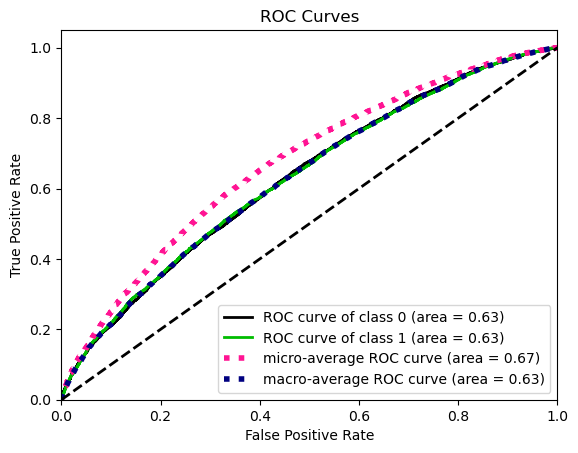

The AUC Value for the model is 0.6301494626892303
The thresholds tried are, [       inf 0.99991495 0.99461061 ... 0.113322   0.11132093 0.0562074 ]


In [18]:
# QDA Train Prediction
lda_train_pred = lda_train.predict(train2)
lda_train_prob = lda_train.predict_proba(train2)

# LDA Test Validation
lda_test = lda_train.predict(test2)
lda_test_prob = lda_train.predict_proba(test2)

# Confusion Matrices of Test Data
print("The Training Classification table is \n", confusion_matrix(y_train, lda_train_pred))
print("The Testing Classification table is \n", confusion_matrix(y_test, lda_test))
print(classification_report(y_train, lda_train_pred))
print(classification_report(y_test, lda_test))

# LDA Metrics - Test Data
fpr, tpr, tholds = metrics.roc_curve(y_test, lda_test_prob[:,1])
scplt.metrics.plot_roc(y_test, lda_test_prob)
plt.show()

print("The AUC Value for the model is", metrics.auc(fpr, tpr))
print("The thresholds tried are,", tholds)

The Training Classification table is 
 [[10250  2039]
 [ 5966  2334]]
The Testing Classification table is 
 [[23864  4726]
 [13866  5584]]
              precision    recall  f1-score   support

           0       0.63      0.83      0.72     28590
           1       0.54      0.29      0.38     19450

    accuracy                           0.61     48040
   macro avg       0.59      0.56      0.55     48040
weighted avg       0.60      0.61      0.58     48040

              precision    recall  f1-score   support

           0       0.63      0.83      0.72     12289
           1       0.53      0.28      0.37      8300

    accuracy                           0.61     20589
   macro avg       0.58      0.56      0.54     20589
weighted avg       0.59      0.61      0.58     20589



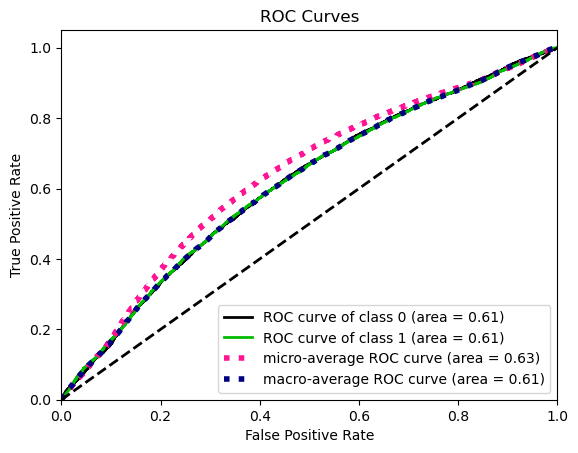

The AUC Value for the model is 0.611443415455295
The thresholds tried are, [            inf 1.00000000e+000 1.00000000e+000 ... 3.88781036e-196
 4.73833608e-293 0.00000000e+000]


In [17]:
# QDA Train Prediction
qda_train_pred = qda_train.predict(train2)
qda_train_prob = qda_train.predict_proba(train2)

# QDA Test Validation
qda_test = qda_train.predict(test2)
qda_test_prob = qda_train.predict_proba(test2)

# Confusion Matrices Data
print("The Training Classification table is \n", confusion_matrix(y_test, qda_test))
print("The Testing Classification table is \n", confusion_matrix(y_train, qda_train_pred))
print(classification_report(y_train, qda_train_pred))
print(classification_report(y_test, qda_test))

# QDA Metrics - Test Data
fpr, tpr, tholds = metrics.roc_curve(y_test, qda_test_prob[:,1])
scplt.metrics.plot_roc(y_test, qda_test_prob)
plt.show()

print("The AUC Value for the model is", metrics.auc(fpr, tpr))
print("The thresholds tried are,", tholds)

#### How often in train and test do LDA and QDA make the same prediction?

In [16]:
from sklearn.metrics import accuracy_score

# Step 3: Compare the predictions
# For training data
same_pred_train = (lda_train_pred == qda_train_pred)
percent_same_train = np.mean(same_pred_train) * 100
print(f"Percentage of same predictions on training data: {percent_same_train:.2f}%")

# For testing data
same_pred_test = (lda_test == qda_test)
percent_same_test = np.mean(same_pred_test) * 100
print(f"Percentage of same predictions on testing data: {percent_same_test:.2f}%")


Percentage of same predictions on training data: 86.36%
Percentage of same predictions on testing data: 86.51%


### Step 4: Summarize Results for both Training and Test

#### Which model yields the best predictions overall, and which models yielded the best predictions of "Yes"? Do you like the model? Did it predict as well as you expected it to predict?
Neither LDA nor QDA demonstrate strong performance in terms of accuracy, precision, recall, or F1 score.The recall values are quite low for both models, indicating that the models have difficulty identifying instances of "Yes" for readmission.

LDA slightly outperforms QDA in terms of precision, recall, and F1 score, both in the training and test sets.
Considering the overall performance and the percentage of same predictions, LDA may be slightly preferred over QDA due to its slightly better performance in terms of precision, recall, and F1 score. In conclusion, while the LDA model yields slightly better predictions overall and for "Yes" instances compared to the QDA model, both models fall short of providing satisfactory performance. Given the healthcare setting, where it is likely preferable to label healthy patients as sick than visa-versa, we prefer the model with higher recall, all else equal.